**Task Description**

Competition is based on Silicon Valley movie:
https://www.youtube.com/watch?v=vIci3C4JkL0&t=38s

You need to predict whether there is a hot dog in the image or not. 
The probability that there is a hot dog on the image must be written to the solution file.
The quality of the model will be measured using the AUC-ROC metric.

**Results**

Here we used CNN based on a pre-trained Xception model with data augmentation, wich allowed to take the 2nd place on the private [leaderboard](https://www.kaggle.com/c/spbu-hotdog/leaderboard)


In [ ]:
# classic libraries
import os
import numpy as np
import pandas as pd

# sklearn for splitting and testing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# visualization libraries
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

# tensorflow/ keras libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


**Data Description**

train.zip - an archive of pictures from the training set. Contains 2 folders: hot-dot and not-hot-dog

test.zip - archive with pictures of the test set. For these images, you need to predict the likelihood that there is a hot dog in the picture.

In [ ]:
!unzip -q -o 'spbu-hotdog.zip'

In [ ]:
SEED = 257

TRAIN_DIR = 'train/train/'
TEST_DIR = 'test/test/'

In [ ]:
# create a train dataset
X, y = [], []
categories = ['hot dog', 'not hot dog']

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append(imread(os.path.join(category_dir, image_path)))
        y.append(category)
        
y = [1 if x == 'hot dog' else 0 for x in y]

# Data check and preparation

In [ ]:
len(X), len(y)

(10049, 10049)

In [ ]:
X[0].shape

(100, 100, 3)

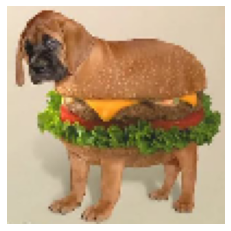

In [ ]:
plt.axis("off");
plt.imshow(X[100]);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.25, random_state=SEED)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7536, 100, 100, 3), (2513, 100, 100, 3), (7536,), (2513,))

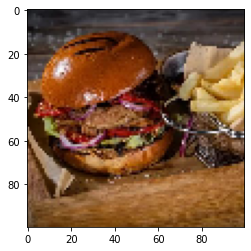

In [ ]:
plt.imshow(X_train[7534]);

In [ ]:
def train_preprocess(X_train, X_test, y_train, y_test):
  # some changes of train sample to prepare it for CNN fitting

  img_rows = 100
  img_cols = 100
  num_classes = 2

  if K.image_data_format() == 'channels_first':
      x_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
      x_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
      input_shape = (3, img_rows, img_cols)
  else:
      x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
      x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
      input_shape = (img_rows, img_cols, 3)

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  y_train = to_categorical(y_train, 2)
  y_test = to_categorical(y_test, 2)
  y_train = y_train.reshape((-1,2))

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_preprocess(X_train, X_test, y_train, y_test)

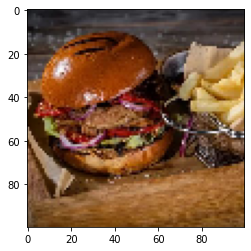

In [ ]:
plt.imshow(x_train[7534]);

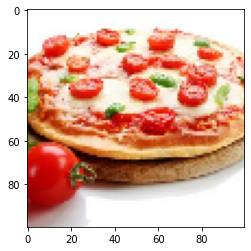

In [ ]:
plt.imshow(x_test[2]);

# Transfer learning

In [ ]:
# import necessary libraries for transfer learning
from tensorflow import keras
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import Nadam
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D

In [ ]:
# buld a new model based on pre-trained Xception network
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200,activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(170,activation='elu')(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
len(base_model.layers)

132

In [ ]:
# freeze all layers of the base model except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# apply data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
# compile the model
model2.compile(optimizer=Nadam(lr=0.0001), 
loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [ ]:
# fit the model
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train)/32, epochs=1,
          verbose=1, validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


235/235 [==============================] - 559s 2s/step - loss: 0.1367 - auc: 0.9824 - val_loss: 0.1183 - val_auc: 0.9848


In [ ]:
roc_auc_score(y_test, model2.predict(x_test))

0.9735939996714604

# Predictions 

In [ ]:
# create a test dataset

leaderboard_X = []
leaderboard_filenames = []
for image_path in os.listdir(TEST_DIR):
    leaderboard_X.append(imread(os.path.join(TEST_DIR, image_path)))
    leaderboard_filenames.append(image_path)

In [ ]:
# check shapes
print(leaderboard_X[0].shape, leaderboard_filenames[0])

In [ ]:
# predict
X_test_t = np.array(leaderboard_X)
leaderboard_predictions = model2.predict(X_test_t)[:,1]
leaderboard_predictions = leaderboard_predictions.tolist()

In [ ]:
def check_prediction(idx):
  # function shows the prediction for a certain image
  font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 22,
    }
  
  plt.axis("off");

  if leaderboard_predictions[idx] > 0.5:
      plt.text(20, -5, 'HOT DOG!!!', fontdict=font)
  else:
      plt.text(15, -5,'not hot dog...', fontdict=font)
  plt.imshow(leaderboard_X[idx]);

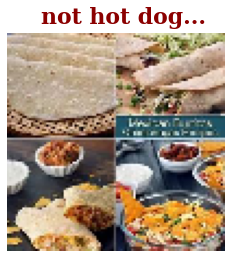

In [ ]:
check_prediction(54)

In [ ]:
# create a submission file for Kaggle

submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': leaderboard_predictions}
)
submission.head()

In [ ]:
submission.to_csv(path_or_buf='submission_hotdogs3.csv', index=False)